In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

import datetime
from WindPy import w
w.start()

Welcome to use Wind Quant API for Python (WindPy)!

COPYRIGHT (C) 2020 WIND INFORMATION CO., LTD. ALL RIGHTS RESERVED.
IN NO CIRCUMSTANCE SHALL WIND BE RESPONSIBLE FOR ANY DAMAGES OR LOSSES CAUSED BY USING WIND QUANT API FOR Python.


.ErrorCode=0
.Data=[OK!]

In [2]:
def stock_data(stockList, factor, startDate, endDate):
    data = w.wsd(stockList, factor, startDate, endDate, "")
    df = pd.DataFrame(data.Data, columns = data.Times, index = stockList).T
    return df

In [3]:
def weight_stock(m, ratio, weights):
    N_sect = 10
    bins = [i+(max(m)-min(m))/N_sect for i in np.arange(min(m),max(m),(max(m)-min(m))/N_sect)][:-1]
    bins.append(ratio)
    bins.sort()
    index = bins.index(ratio)
    return np.around(weights[index],decimals =2)

In [4]:
def updateMoney(t,t_lasttime,weights,money,stockClose,merged_data):
    dailyReturnOfBond = merged_data.loc[t_lasttime: t]['bond10y'].mean()/365
    bondIncome = (t-t_lasttime).days * dailyReturnOfBond * (1-weights) * money
    stockIncome = (stockClose[t]-stockClose[t_lasttime])/stockClose[t_lasttime] * weights * money
    money += (stockIncome + bondIncome)
    return money

In [5]:
def weight_stock_comprehensive(returnRatio_temp, t, weights):
    returnRatio_temp_t = returnRatio_temp[:t]
    N_sect = 10
    i_best = returnRatio_temp_t.columns[0]
    index_best = -1
    for i in returnRatio_temp_t:
        m = returnRatio_temp_t[i]
        bins = [i+(max(m)-min(m))/N_sect for i in np.arange(min(m),max(m),(max(m)-min(m))/N_sect)][:-1]
        bins.append(returnRatio_temp_t.loc[t][i])
        bins.sort()
        index = bins.index(returnRatio_temp_t.loc[t][i])
        if index > index_best:
            i_best = i
            index_best = index
    return [i_best,np.around(weights[index_best],decimals =2)]

In [6]:
stockList = ["000300.SH","000905.SH","399006.SZ","881001.WI"]
startDate = "20110101"
endDate = "20210101"
testStartDate  = datetime.date.fromisoformat('2016-01-04')
N = 1 # N-month return of index

stockPEdf = stock_data(stockList, "pe_ttm", startDate, endDate)
bond10y = w.edb("M1001654", startDate, endDate)
bonddf = pd.DataFrame(bond10y.Data,columns = bond10y.Times, index = ["bond10y"]).T/100
merged_data = pd.concat([1/stockPEdf,bonddf],axis = 1,join = 'inner')

returnRatio = pd.DataFrame(index = stockList,columns = merged_data.index).T
for i in stockList:
    returnRatio[i] = merged_data[i].T / merged_data[merged_data.columns[-1]].T
returnRatio = np.around(returnRatio, decimals = 2, out = None)

stockClosedf = stock_data(stockList, 'CLOSE', startDate, endDate)

In [7]:
# pd.set_option('display.max_rows', None)
# returnRatio

## 四种指数（沪深300、中证500、创业板、万得全A）股债比

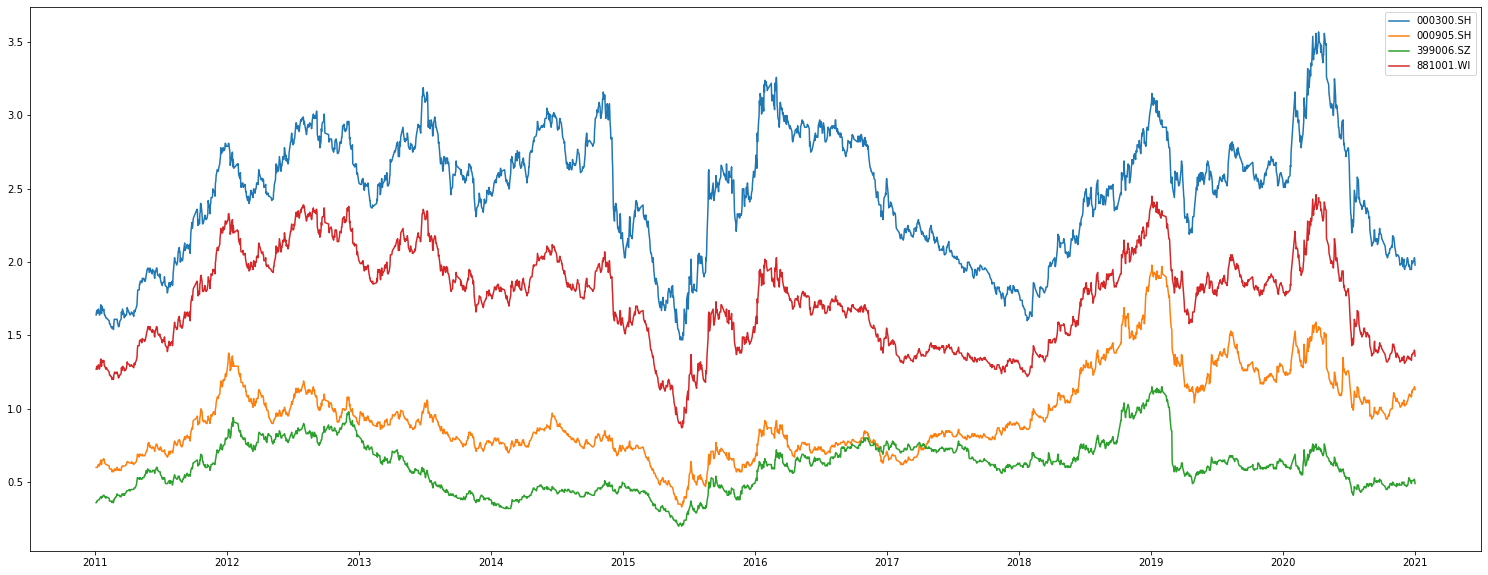

In [8]:
plt.figure(figsize=(26,10))
for i in returnRatio:
    plt.plot(returnRatio[i],label = i)
plt.legend()

In [9]:
def return_strategy_benchmark(testStartDate,returnRatio,stockClosedf,merged_data):
    m = returnRatio[returnRatio.columns[-1]]
    stockClose = stockClosedf[stockClosedf.columns[-1]]
    weights_assigned = [i for i in np.arange(0,1,0.1)]

    t = t_lasttime = testStartDate
    weights_new = weights_lasttime = weight_stock(m[:t],m[t],weights_assigned)
    money = 1

    time_all = []
    money_all = []
    index_all = []
    position_all = []
    time_all.append(t)
    money_all.append(money)
    index_all.append(stockClose[t])
    position_all.append(weights_new)

    testStart_indexNum = m.index.tolist().index(testStartDate)
    for i in range(testStart_indexNum+1,len(m)):   
        if i%21 == 0:
            weights_new = weight_stock(m[:(i+1)],m[i],weights_assigned)
            t = m.index[i]
            money = updateMoney(t,t_lasttime, weights_lasttime,money,stockClose,merged_data)
            weights_lasttime = weights_new
            t_lasttime = t

            time_all.append(t)
            money_all.append(money)
            index_all.append(stockClose[t])
            position_all.append(weights_new)

    startYear = str(testStartDate).split("-")[0]
    if startYear == '2014':
        denominator = 7
    elif startYear == '2015':
        denominator = 6
    elif startYear == '2016':
        denominator = 5
    elif startYear == '2017':
        denominator = 4
    print(m.name)
    print("训练开始日期("+str(stockClose.index[0])+")："+str(stockClose[0]) + "   测试开始日期("+str(testStartDate)+")："+str(stockClose[testStart_indexNum+1]) +"    结束日期("+str(stockClose.index[-1])+")："+str(stockClose[-1]))
    print("指数总收益率： " + str(stockClose[-1]/stockClose[testStart_indexNum+1] - 1) + "   指数年化收益率： " + str((stockClose[-1]/stockClose[testStart_indexNum+1])**(1/denominator) - 1))
    print("策略总收益率： " + str(money - 1) + "   策略年化收益率： " + str(money**(1/denominator) - 1))
    print()
    return[time_all,money_all,position_all]

# 仅含万得全A策略

In [10]:
[time_all,money_all,position_all] = return_strategy_benchmark(testStartDate,returnRatio,stockClosedf,merged_data)

881001.WI
训练开始日期(2011-01-04)：2780.821   测试开始日期(2016-01-04)：4482.7447    结束日期(2020-12-31)：5422.197
指数总收益率： 0.20957077925941214   指数年化收益率： 0.0387864052636544
策略总收益率： 0.4708150797127837   策略年化收益率： 0.08021850986896628



## 万得全A历史走势

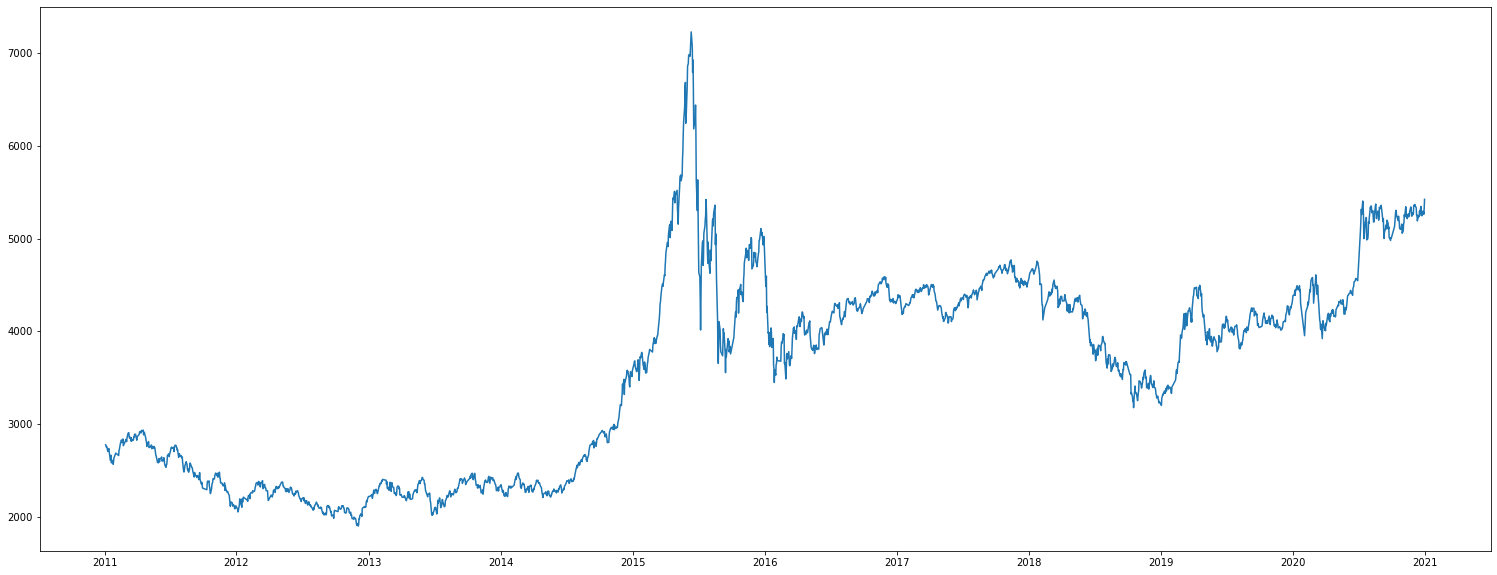

In [11]:
plt.figure(figsize=(26,10))
plt.plot(stockClosedf[stockClosedf.columns[-1]])

## 策略资金变化和股票仓位比关系

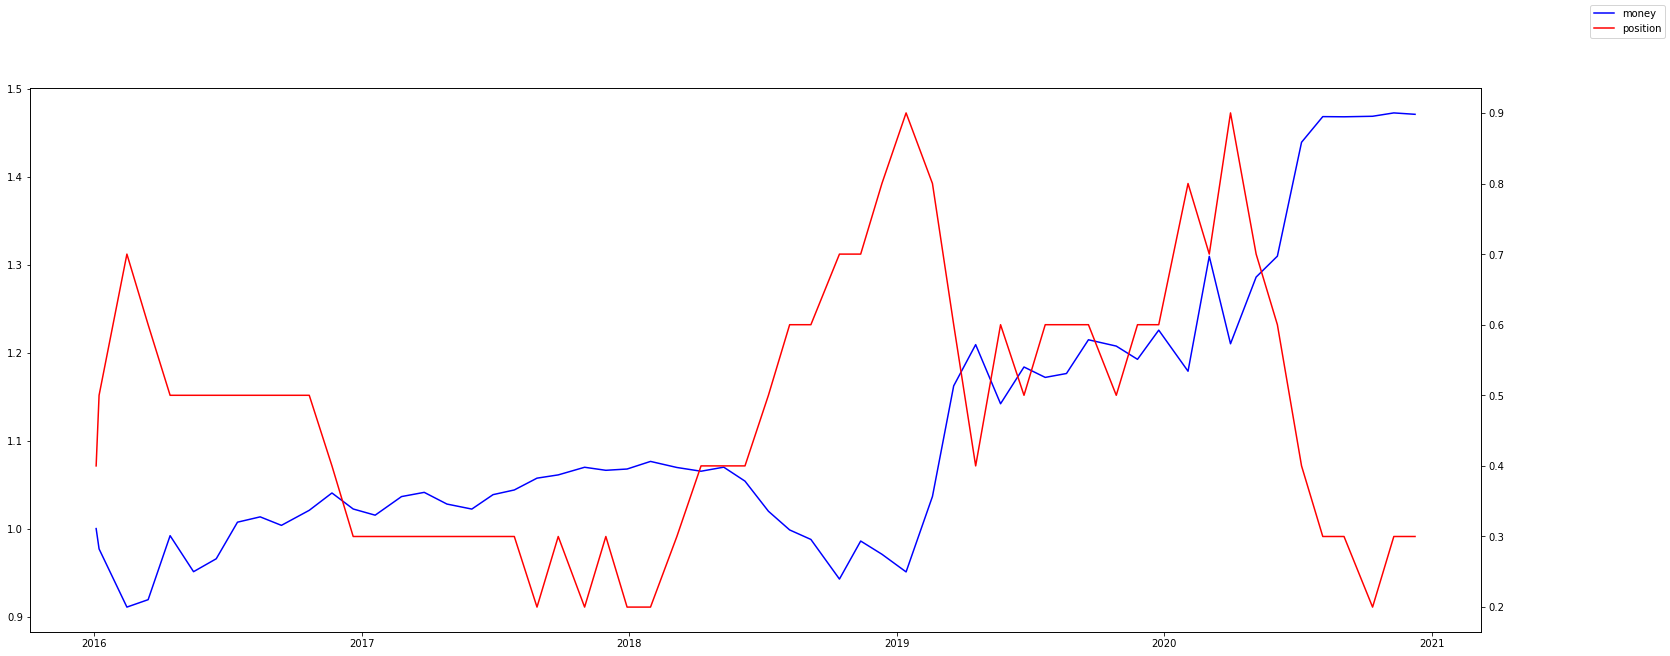

In [12]:
fig = plt.figure(figsize=(26,10))
ax1 = fig.add_subplot(111)
ax1.plot(time_all,money_all,color = 'blue',label = 'money')
ax1.xaxis.set_major_locator(ticker.MultipleLocator(150))
# ax1.grid()
ax2 = ax1.twinx() 
ax2.plot(time_all,position_all,color = 'red',label = 'position')
fig.legend()

## 收益率变化情况

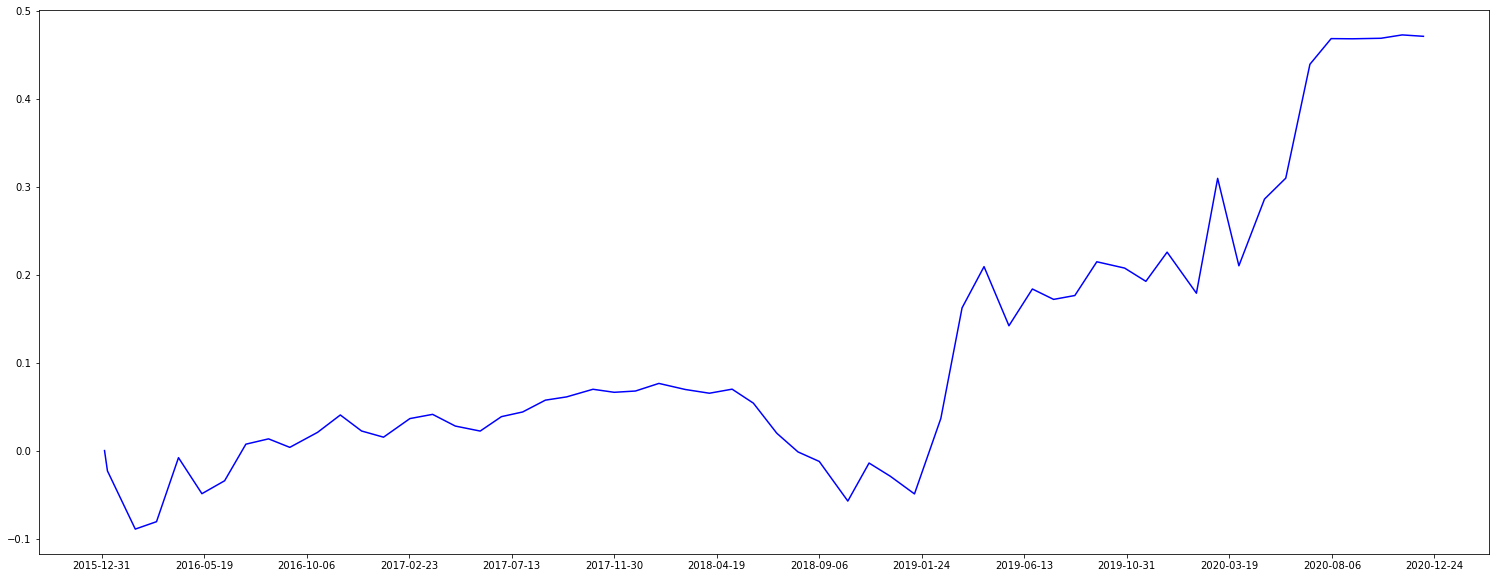

In [13]:
import matplotlib.ticker as ticker
fig = plt.figure(figsize=(26,10))
ax1 = fig.add_subplot(111)
ax1.plot(time_all,[i-1 for i in money_all],color = 'blue')
ax1.xaxis.set_major_locator(ticker.MultipleLocator(140))
# ax1.grid()
# ax2 = ax1.twinx() 
# ax1.plot(time_all,[i-1 for i in money_all/money_all[0]],color = 'red')

## 策略最大回撤

In [14]:
max_drawdown = 0
max_drawdown_start = 0
max_drawdown_end = 0
for i in range(len(money_all)):
    for j in range(i+1,len(money_all)):
        if (money_all[i]-money_all[j])>max_drawdown:
            max_drawdown_start = i
            max_drawdown_end = j
            max_drawdown = money_all[i]-money_all[j]
print("策略最大回撤："+str(max_drawdown/money_all[max_drawdown_start])+"   时间："+str(time_all[max_drawdown_start]) + "("+str(np.around(money_all[max_drawdown_start],decimals =3))
      +") 至 "+str(time_all[max_drawdown_end])+ "("+str(np.around(money_all[max_drawdown_end],decimals =3))+")")

策略最大回撤：0.12422940198870602   时间：2018-01-30(1.076) 至 2018-10-15(0.943)


In [15]:
stockClose = stockClosedf[stockClosedf.columns[-1]]
info = pd.DataFrame([time_all,money_all,position_all], index=['时间', '资金', '仓位']).T.set_index(['时间'])
info['策略收益率'] = np.log((info['资金'].to_frame()/info['资金'].to_frame().shift()).fillna(value = 1))
info = pd.concat([info,stockClose.to_frame()],axis =1,join='inner')
info['指数收益率'] = np.log((info['881001.WI'].to_frame()/info['881001.WI'].to_frame().shift()).fillna(value = 1))
info

,资金,仓位,策略收益率,881001.WI,指数收益率
2016-01-04,1,0.4,0.000000,4534.4075,0.000000
2016-01-08,0.976896,0.5,-0.023375,4270.3716,-0.059994
2016-02-15,0.910772,0.7,-0.070088,3679.7448,-0.148857
2016-03-15,0.919201,0.6,0.009212,3724.8118,0.012173
2016-04-14,0.991936,0.5,0.076154,4210.2105,0.122496
2016-05-16,0.951005,0.5,-0.042140,3852.0140,-0.088917
2016-06-16,0.965699,0.5,0.015333,3961.3543,0.027990
2016-07-15,1.007274,0.5,0.042151,4293.4247,0.080499
2016-08-15,1.013319,0.5,0.005984,4334.8756,0.009608
2016-09-13,1.003664,0.5,-0.009574,4242.8843,-0.021450


## 策略表现
### 年化波动率计算：标准差*(N^0.5)

In [16]:
time_temp = ['2016年','2017年','2018年','2019年','2020年','五年总计'] 
return_temp = [money_all[12]/money_all[0]-1,money_all[24]/money_all[12]-1,money_all[35]/money_all[24]-1,money_all[47]/money_all[35]-1,money_all[-1]/money_all[47]-1,money_all[-1]/money_all[0]-1]
money_temp = [money_all[12],money_all[24],money_all[35],money_all[47],money_all[-1],money_all[-1]]
return_volatility = [info.iloc[:13].std()[2]*(13**0.5),info.iloc[13:25].std()[2]*(12**0.5),info.iloc[25:36].std()[2]*(11**0.5),
                     info.iloc[36:48].std()[2]*(12**0.5),info.iloc[48:].std()[2]*(11**0.5)]
return_volatility.append(sum([i/len(return_volatility) for i in return_volatility]))

index_temp = [stockClose.loc[info.index[12]],stockClose.loc[info.index[24]],stockClose.loc[info.index[35]],stockClose.loc[info.index[47]],stockClose.loc[info.index[-1]],stockClose.loc[info.index[-1]]]
index_return = [stockClose.loc[info.index[12]]/stockClose.loc[info.index[0]]-1,stockClose.loc[info.index[24]]/stockClose.loc[info.index[12]]-1,stockClose.loc[info.index[35]]/stockClose.loc[info.index[24]]-1,
               stockClose.loc[info.index[47]]/stockClose.loc[info.index[35]]-1,stockClose.loc[info.index[-1]]/stockClose.loc[info.index[47]]-1,stockClose.loc[info.index[-1]]/stockClose.loc[info.index[0]]-1]
index_return_volatility = [info.iloc[:13].std()[4]*(13**0.5),info.iloc[13:25].std()[4]*(12**0.5),info.iloc[25:36].std()[4]*(11**0.5),
                           info.iloc[36:48].std()[4]*(12**0.5),info.iloc[48:].std()[4]*(11**0.5)]
index_return_volatility.append(sum([i/len(index_return_volatility) for i in index_return_volatility]))

info_temp = pd.DataFrame([time_temp,money_temp,return_temp,return_volatility,index_temp,index_return,index_return_volatility], 
                         index=['时间','资金', '策略收益率','策略年化波动率','指数','指数收益率','指数年化波动率']).T.set_index(['时间'])
info_temp

,资金,策略收益率,策略年化波动率,指数,指数收益率,指数年化波动率
时间,,,,,,
2016年,1.022262,0.022262,0.132407,4319.2698,-0.047446,0.25711
2017年,1.067686,0.044434,0.034099,4522.7222,0.047103,0.115706
2018年,0.970835,-0.090711,0.078602,3425.7215,-0.242553,0.14819
2019年,1.225518,0.262335,0.164085,4232.5594,0.235523,0.262494
2020年,1.470815,0.200158,0.178794,5249.2885,0.240216,0.258442
五年总计,1.470815,0.470815,0.117597,5249.2885,0.157657,0.208388


In [17]:
def return_strategy_benchmark_comprehensive(testStartDate,returnRatio,stockClosedf,merged_data):
    m = returnRatio[returnRatio.columns[-1]]
    stockClose = stockClosedf[stockClosedf.columns[-1]]
    weights_assigned = [i for i in np.arange(0,1,0.1)]

    t = t_lasttime = testStartDate
    weights_new = weights_lasttime = weight_stock(m[:t],m[t],weights_assigned)
    stock_lasttime = weight_stock_comprehensive(returnRatio, t, weights_assigned)[0]

    money = 1
    time_all = []
    money_all = []
    position_all = []
    stock_all = []
    
    time_all.append(t)
    money_all.append(money)
    position_all.append(weights_new)
    stock_all.append(stock_lasttime)

    testStart_indexNum = m.index.tolist().index(testStartDate)
    for i in range(testStart_indexNum+1,len(m)):   
        if i%21 == 0:
            weights_new = weight_stock(m[:(i+1)],m[i],weights_assigned)
            t = m.index[i]
            money = updateMoney(t,t_lasttime, weights_lasttime,money,stockClosedf[stock_lasttime],merged_data)
            weights_lasttime = weights_new
            t_lasttime = t
            stock_lasttime = weight_stock_comprehensive(returnRatio, t, weights_assigned)[0]
            
            time_all.append(t)
            money_all.append(money)
            position_all.append(weights_new)
            stock_all.append(stock_lasttime)

    startYear = str(testStartDate).split("-")[0]
    if startYear == '2014':
        denominator = 7
    elif startYear == '2015':
        denominator = 6
    elif startYear == '2016':
        denominator = 5
    elif startYear == '2017':
        denominator = 4
#     print(m.name)
    print("训练开始日期("+str(stockClose.index[0])+")："+str(stockClose[0]) + "   测试开始日期("+str(testStartDate)+")："+str(stockClose[testStart_indexNum+1]) +"    结束日期("+str(stockClose.index[-1])+")："+str(stockClose[-1]))
    print("指数总收益率： " + str(stockClose[-1]/stockClose[testStart_indexNum+1] - 1) + "   指数年化收益率： " + str((stockClose[-1]/stockClose[testStart_indexNum+1])**(1/denominator) - 1))
    print("策略总收益率： " + str(money - 1) + "   策略年化收益率： " + str(money**(1/denominator) - 1))
    print()
    return[time_all,money_all,position_all,stock_all]

# 含四种指数的策略

In [18]:
[time_all,money_all,position_all,stock_all] = return_strategy_benchmark_comprehensive(testStartDate,returnRatio,stockClosedf,merged_data)

训练开始日期(2011-01-04)：2780.821   测试开始日期(2016-01-04)：4482.7447    结束日期(2020-12-31)：5422.197
指数总收益率： 0.20957077925941214   指数年化收益率： 0.0387864052636544
策略总收益率： 0.35680021124527395   策略年化收益率： 0.06292636746673774



## 策略资金变化和股票仓位比关系
### 2018年年中，股债比不低，导致股票仓位高，亏损严重

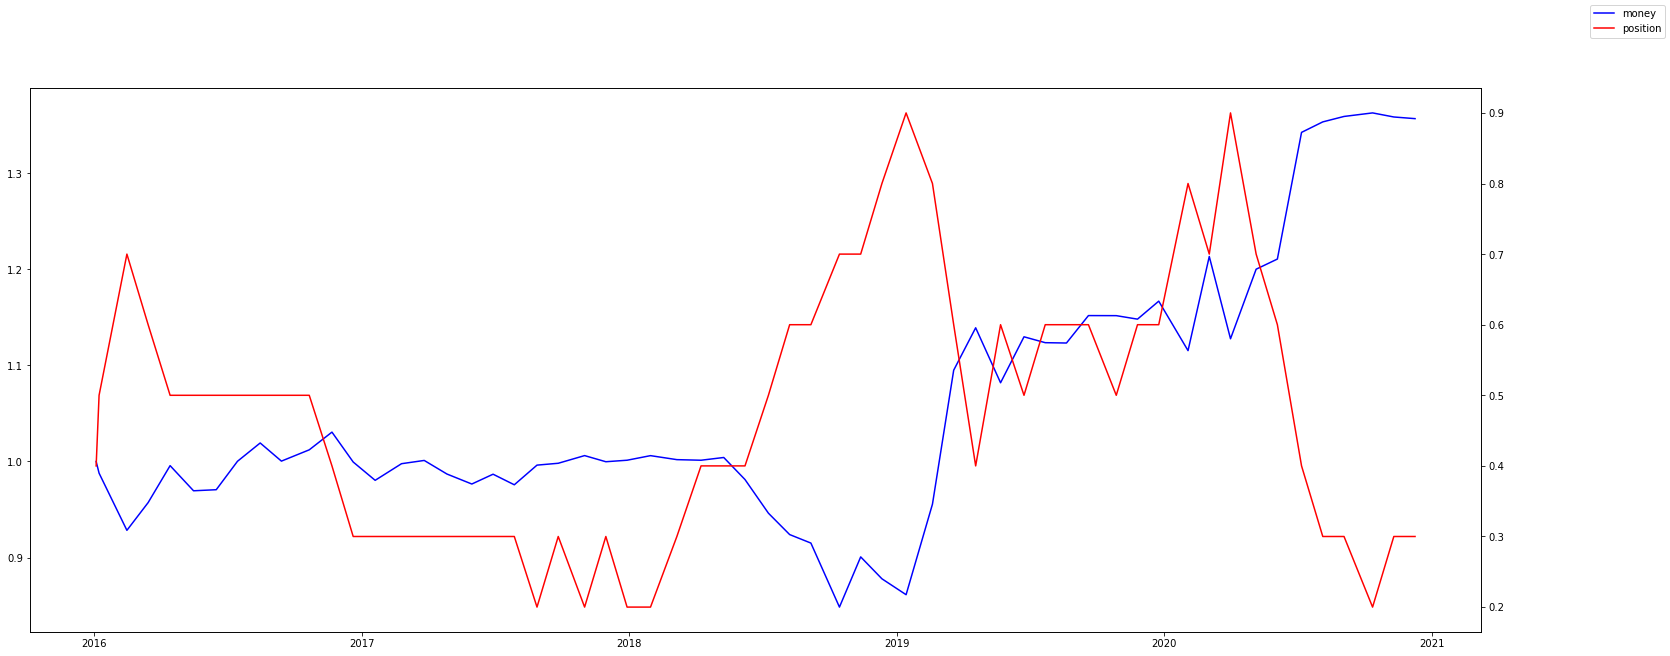

In [19]:
fig = plt.figure(figsize=(26,10))
ax1 = fig.add_subplot(111)
ax1.plot(time_all,money_all,color = 'blue',label = 'money')
ax1.xaxis.set_major_locator(ticker.MultipleLocator(150))
# ax1.grid()
ax2 = ax1.twinx() 
ax2.plot(time_all,position_all,color = 'red',label = 'position')
fig.legend()

## 收益率变化情况

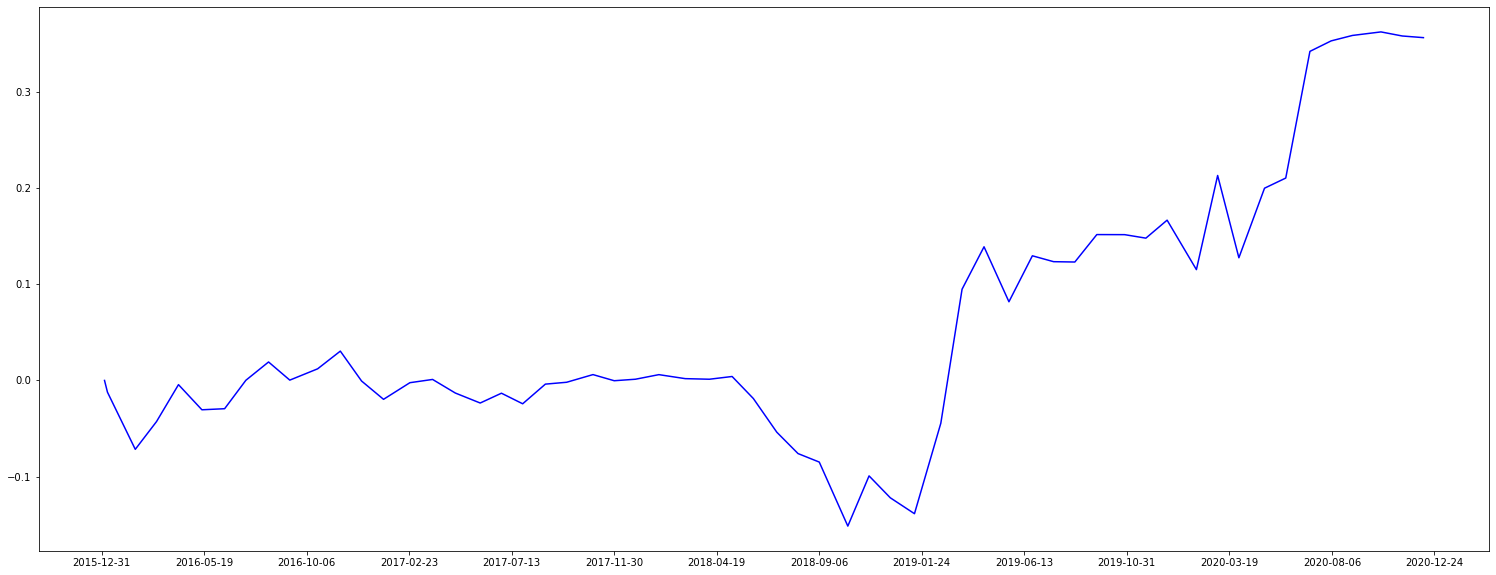

In [20]:
import matplotlib.ticker as ticker
fig = plt.figure(figsize=(26,10))
ax1 = fig.add_subplot(111)
ax1.plot(time_all,[i-1 for i in money_all],color = 'blue')
ax1.xaxis.set_major_locator(ticker.MultipleLocator(140))
# ax1.grid()
# ax2 = ax1.twinx() 
# ax1.plot(time_all,[i-1 for i in index_all/index_all[0]],color = 'red')

## 策略最大回撤

In [21]:
max_drawdown = 0
max_drawdown_start = 0
max_drawdown_end = 0
for i in range(len(money_all)):
    for j in range(i+1,len(money_all)):
        if (money_all[i]-money_all[j])>max_drawdown:
            max_drawdown_start = i
            max_drawdown_end = j
            max_drawdown = money_all[i]-money_all[j]
print("策略最大回撤："+str(max_drawdown/money_all[max_drawdown_start])+"   时间："+str(time_all[max_drawdown_start]) + "("+str(np.around(money_all[max_drawdown_start],decimals =3))
      +") 至 "+str(time_all[max_drawdown_end])+ "("+str(np.around(money_all[max_drawdown_end],decimals =3))+")")

策略最大回撤：0.17672989531571393   时间：2016-11-21(1.031) 至 2018-10-15(0.848)


In [22]:
info = pd.DataFrame([time_all,money_all,position_all,stock_all], index=['时间', '资金', '仓位','股票']).T.set_index(['时间'])
info['收益率'] = np.log((info['资金'].to_frame()/info['资金'].to_frame().shift()).fillna(value = 1))
info

,资金,仓位,股票,收益率
时间,,,,
2016-01-04,1,0.4,000300.SH,0.000000
2016-01-08,0.987793,0.5,000300.SH,-0.012283
2016-02-15,0.928287,0.7,000300.SH,-0.062131
2016-03-15,0.957163,0.6,000300.SH,0.030632
2016-04-14,0.995614,0.5,000300.SH,0.039387
2016-05-16,0.969451,0.5,000300.SH,-0.026630
2016-06-16,0.970572,0.5,000300.SH,0.001156
2016-07-15,1.000154,0.5,000300.SH,0.030024
2016-08-15,1.019209,0.5,000300.SH,0.018873


## 策略表现

In [25]:
time_temp = ['2016年','2017年','2018年','2019年','2020年','五年总计'] 
return_temp = [money_all[12]/money_all[0]-1,money_all[24]/money_all[12]-1,money_all[35]/money_all[24]-1,money_all[47]/money_all[35]-1,money_all[-1]/money_all[47]-1,money_all[-1]/money_all[0]-1]
money_temp = [money_all[12],money_all[24],money_all[35],money_all[47],money_all[-1],money_all[-1]]
return_volatility = [info.iloc[:13].std()[2]*(13**0.5),info.iloc[13:25].std()[2]*(12**0.5),info.iloc[25:36].std()[2]*(11**0.5),
                     info.iloc[36:48].std()[2]*(12**0.5),info.iloc[48:].std()[2]*(11**0.5)]
return_volatility.append(sum([i/len(return_volatility) for i in return_volatility]))

info_temp = pd.DataFrame([time_temp,money_temp,return_temp,return_volatility], index=['时间','资金', '策略收益率', '策略波动率']).T.set_index(['时间'])
info_temp

,资金,策略收益率,策略波动率
时间,,,
2016年,0.999399,-0.000601,0.105226
2017年,1.001256,0.001858,0.04404
2018年,0.877844,-0.123258,0.109682
2019年,1.166826,0.329195,0.180815
2020年,1.3568,0.162813,0.172835
五年总计,1.3568,0.3568,0.122519
